### Sprint11 深層学習スクラッチ 畳み込みニューラルネットワーク１

1次元の畳み込みニューラルネットワークスクラッチ

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

#### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

#### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics
from scipy import stats
import collections
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$ : 出力される配列のi番目の値


$F$ : フィルタのサイズ


$x_{(i+s)}$ : 入力の配列の(i+s)番目の値


$w_s$ : 重みの配列のs番目の値


$b$ : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値


$N_{out}$ : 出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$$
$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値


ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

$$

In [4]:
class conv1D_1CH:
    """
    チャネル１、スライド１、パディングなし、バッチサイズ１
    """
    
    def __init(self):
        self.x = None
        self.w = None
        self.b = None
        
    def forward(self, x, w, b):
        # backward用に確保
        self.x = x
        self.w = w
        self.b = b
        # forward計算
        delta = self.x.shape[0] -self.w.shape[0]
        a = np.zeros(delta+1)
        for n in range(delta+1):
            a[n] = (self.x[n:self.w.shape[0]+n]*self.w).sum() + self.b
        return a
    
    def backward(self, delta_a):
        # delta_b
        delta_b = np.array([delta_a.sum()])
        # delta_w
        delta_w = np.empty(self.w.shape[0])
        for n in range(self.w.shape[0]):
            delta_w[n] = delta_a.dot(self.x[n:n+delta_a.shape[0]])
        # delta_x
        delta_x = np.pad(self.w, [0,1], 'constant')*delta_a[0] + np.pad(self.w, [1,0], 'constant')*delta_a[1] 
        return delta_b, delta_w, delta_x

In [7]:
# 問題３についてclassを使用して畳み込み計算

# 入力x、重みw、バイアスb
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
# 誤差
delta_a = np.array([10, 20])

conv1_ch = conv1D_1CH()
print("a : ", conv1_ch.forward(x, w, b))
print("delta_b, delta_w, delta_x : ", conv1_ch.backward(delta_a))

a :  [35. 50.]
delta_b, delta_w, delta_x :  (array([30]), array([ 50.,  80., 110.]), array([ 30, 110, 170, 140]))


### 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ

In [8]:
def get_outsize(n_in, P, F, S):
    n_out = (n_in + 2*P - F)/S + 1
    if n_out!=int(n_out):
        # n_outが割り切れない場合、強制終了
        print("出力サイズが割り切れません。パディングとストライドを再設定して下さい。")
        return
    return int(n_out)

In [9]:
# 問題３について出力サイズ計算
get_outsize(4, 0, 3, 1)

2

#### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

In [10]:
# 入力x、重みw、バイアスb
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [11]:
# 出力（答え）
# a = np.array([35, 50])

# 畳み込み計算
a = np.array([(x[:3]*w).sum()+1, (x[1:]*w).sum()+1])
print("a", a)

a [35 50]


In [12]:
# 誤差
delta_a = np.array([10, 20])

In [13]:
# バックプロパゲーション（答え）
# delta_b = np.array([30])
# delta_w = np.array([50, 80, 110])
# delta_x = np.array([30, 110, 170, 140])

# バックプロパゲーション計算
delta_b = np.array([delta_a[0]+delta_a[1]])
delta_w = np.array([delta_a[0]*x[0]+delta_a[1]*x[1],
                   delta_a[0]*x[1]+delta_a[1]*x[2],
                   delta_a[0]*x[2]+delta_a[1]*x[3]])
delta_x = np.array([delta_a[0]*w[0],
                    delta_a[0]*w[1]+delta_a[1]*w[0],
                    delta_a[0]*w[2]+delta_a[1]*w[1],
                    delta_a[1]*w[2]])
print("delta_b", delta_b)
print("delta_w", delta_w)
print("delta_x", delta_x)

delta_b [30]
delta_w [ 50  80 110]
delta_x [ 30 110 170 140]


#### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、

In [14]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は次のようになります

In [16]:
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

《補足》


チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

### 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

### 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。


### 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

### 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [17]:
class conv1D:
    """
    チャネル複数、ストライド複数、パディング複数、バッチサイズ複数
    
    下記をコンストラクタに加える
    input_shape：（バッチ数、channel数、特徴量数）
    w_shape : (出力チャネル、入力チャネル、フィルタサイズ)
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, input_shape, w_shape, P, S):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = initializer
        self.W = self.initializer.W(*w_shape)    # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        self.B = self.initializer.B(w_shape[0])    # (出力チャンネル数)
        # 初期値
        self.Z = None
        #  AdaGrad用の変数
        self.H_B = 0
        self.H_W = 0
        # conv初期値
        self.input_shape = input_shape
        self.w_shape = w_shape
        self.P = P
        self.S = S
        self.n_out = n_nodes2//w_shape[0]
    
    def forward(self, Z): # Z （バッチサイズ、入力チャンネル数、特徴量）
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        # input_shaepを統一する
        if Z.shape!=self.input_shape:
            # 予測時はバッチサイズが異なるため１次元目は「−１」
            Z = Z.reshape(-1, *self.input_shape[1:])
        # backward用に確保
        self.Z = Z
        # forward計算        
        # 出力の初期設定
        A = np.zeros([self.Z.shape[0], self.W.shape[0], self.n_out]) # A （バッチサイズ、出力チャンネル数、特徴量数）
        # パディングに合わせてxを変換
        self.Z = np.pad(self.Z, [(0,0), (0, 0), (self.P, self.P)], 'constant')
        # tensordotによるテンソル積(チャネルファーストに合わせたインデックス)
        Z_index = [i for i in range(self.Z.ndim)]
        W_index = [i for i in range(self.W.ndim)]     
        # バッチに対してブロードキャスト
        # ストライドに合わせる
        for col in range(self.n_out):
            A[:, :, col] = np.tensordot(self.Z[:, :, col*self.S:self.W.shape[2]+col*self.S],
                                                  self.W, axes=(Z_index[1:], W_index[1:])) + self.B
        return A
    
    def backward(self, dA):
        # input_shaepを統一する    
        if dA.shape!=(self.Z.shape[0], self.W.shape[0], self.n_out):
            dA = dA.reshape(self.Z.shape[0], self.W.shape[0], self.n_out) # (バッチサイズ、出力チャンネル数、特徴量数)
        # backwardの計算
        # dB
        dB = dA.sum(axis=(0, -1))
        # dW
        # バッチに対してブロードキャスト(dAのチャネル次元を残すように設計)
        dW = np.zeros_like(self.W)
        for channel in range(dA.shape[1]):
            for col in range(dA.shape[-1]):
                dW[channel, :, :] += (self.Z[:, :, col*self.S:col*self.S+dW.shape[-1]]
                                               *dA[:, channel:channel+1, col:col+1]).sum(axis=0)
        # dZ
        # バッチに対してブロードキャスト
        # ストライドに合わせる
        dZ = np.zeros_like(self.Z)
        for col in range(dA.shape[-1]):
            dZ[:, :, :] += (np.pad(self.W, [(0,0), (0, 0), (col*self.S, (dA.shape[-1]-1-col)*self.S)], 'constant')
                               *dA[:, :, col].reshape(dA.shape[0], -1, 1, 1)).sum(axis=1)
        # パディングの分を削除
        if self.P>0:
            dZ = dZ[:, :, self.P:-self.P]
        
        #  AdaGrad用の計算
        size = dA.shape[0] #バッチサイズ
        self.H_B += (dB/size)**2
        self.H_W += (dW/size)**2
        # 更新(AdaGrad用に引数を設定)
        self.B, self.W = self.optimizer.update(self.B, self.W, dB, dW, self.H_B, self.H_W, size)

        return dZ

In [18]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [19]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    DNNスクラッチ
    Parameters
    ----------
    epoch_count : int
      エポック回数
    layer_act : dic
      layerとact名
    n_nodes : タプル int
      各FCノードの数
    lr : int
      学習率
    activation : obj
      活性化手法のインスタンス
    layer_type : obj
      層のインスタンス
    initializer : obj
      初期化方法のインスタンス
    optimizer : obj
      最適化手法のインスタンス
    sigma : float
      標準偏差、SimpleInitializerのみ入力
    layer_dic : dic
      key : layer名、value : 層のインスタンス
    act_dic : dic
      key : activation名、value : activationのインスタンス
    train_loss : list
      trainのエポック毎のcross_entropyを格納するリスト(エポック毎の平均値)
    val_loss : list
      valのエポック毎のcross_entropyを格納するリスト(全データ分を計算)
    n_features : int
      特徴量の数
    n_output : int
      出力層のノード数
    """
    def __init__(self, epoch_count, layer_act, n_nodes, lr, layer_type,
                      activation,initializer, optimizer, conv_info, sigma=None):
        self.epoch_count = epoch_count
        self.n_nodes = n_nodes
        self.lr = lr
        self.sigma = sigma
        self.layer_type = layer_type
        self.activation = activation
        self.initializer = initializer
        self.optimizer = optimizer
        self.conv_info = conv_info
        self.layer_dic = {}
        self.act_dic = {}
        self.train_loss = []
        self.val_loss = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        # conv1dのoutsizeを取得(size * channel)
        # outsizeが割り切れない場合、強制終了になるよう関数get_outsizeを設定
        conv_outsize = get_outsize(self.conv_info["in_size"], self.conv_info["P"],
                                                 self.conv_info["w_size"], self.conv_info["S"])*self.conv_info["out_ch"]
        # 初期化
        ini_sigma = self.sigma
        n_features = X.shape[1]
        n_output = y.shape[1]
        # 特徴量の数、各ノード数、出力ノード数を結合
        self.n_nodes = list(self.n_nodes)
        self.n_nodes.insert(0, conv_outsize)
        self.n_nodes.insert(0, n_features)
        self.n_nodes.append(n_output)
        # 層の数だけインスタンス化、リストに追加
        num = 0
        nodes_num = len(self.n_nodes) - 1
        for layer, act in layer_act.items():
            # インスタンス時にsigma設定しない場合(AdaGrad)、前のノード数を代入する
            self.sigma = self.n_nodes[num] if ini_sigma is None else ini_sigma
            
            # 最初の層をconv1Dでインスタンス化
            if num == 0:
                # インプット、フィルターのshape設定
                input_shape = (self.conv_info["in_batch"], self.conv_info["in_ch"], self.conv_info["in_size"])
                w_shape = (self.conv_info["out_ch"], self.conv_info["in_ch"], self.conv_info["w_size"])
                # インスタンス化(インプット、フィルター情報もコンストラクタに加える)
                self.layer_dic[layer] = conv1D(self.n_nodes[num], self.n_nodes[num+1], self.initializer(self.sigma),
                                                             self.optimizer(self.lr), input_shape=input_shape, w_shape=w_shape,
                                                             P=self.conv_info["P"], S=self.conv_info["S"])
            # その他の層をインスタンス化
            else:
                self.layer_dic[layer] = self.layer_type(self.n_nodes[num], self.n_nodes[num+1],
                                                                       self.initializer(self.sigma), self.optimizer(self.lr))
        
            # 出力時のみactはSoftmax
            if num+1 == nodes_num:
                self.act_dic[act] = Softmax()
            else:
                self.act_dic[act] = self.activation()
            num += 1
            
        # ミニバッチのインスタンス
        get_mini_batch = GetMiniBatch(X, y, batch_size=20)
        
        # エポック回数繰り返し
        for epoch in range(self.epoch_count):
            # イテレーション回数の初期化
            iter_count = 1
            # イテレーション毎のloss(cross_entropy)記録用array初期化
            train_loss = np.zeros(len(get_mini_batch))
            # イテレーション回数繰り返し
            for mini_X, mini_y in get_mini_batch:
                # 回数の表示
                if iter_count%2400 == 0:
                    print("エポック{}".format(epoch+1))
                    print("{}回目の学習".format(iter_count))
                # 層の数だけforward
                # 処理回数の初期化
                num = 0
                for layer, act in zip(self.layer_dic.values(), self.act_dic.values()):
                    if num==0:
                        Z = mini_X
                    
                    # 最初の層をconv1D、reshapeしてフラット化したのを出力
                    if num==0:
                        A = layer.forward(Z).reshape(mini_X.shape[0], -1)
                    else:
                        A = layer.forward(Z)
                    Z = act.forward(A)
                    num += 1
                   
                # 層の数だけbackward(降順)
                # 逆順用の辞書を作成
                layer_dic_re = {}
                act_dic_re = {}
                for key, item in sorted(self.layer_dic.items(), reverse=True):
                    layer_dic_re[key] = item
                for key, item in sorted(self.act_dic.items(), reverse=True):
                    act_dic_re[key] = item
                # 処理回数の初期化   
                num = 0
                for layer, act in zip(layer_dic_re.values(), act_dic_re.values()):
                    if num==0:
                        # 交差エントロピー誤差とソフトマックスを合わせている
                        dA, train_L = act.backward(mini_y)
                    else:
                        dA = act.backward(dZ)
                    dZ = layer.backward(dA)
                    num += 1   
                # イテレーション毎のloss(cross_entropy)記録
                train_loss[iter_count-1] = train_L
                # イテレーション回数のカウント
                iter_count += 1
             
            # valのlossを計算
            # valのforward
            num = 0
            for layer, act in zip(self.layer_dic.values(), self.act_dic.values()):
                if num==0:
                    Z = X_val

                # 最初の層をconv1D、reshapeしてフラット化したのを出力
                if num==0:
                    A = layer.forward(Z).reshape(X_val.shape[0], -1)
                else:
                    A = layer.forward(Z)
                Z = act.forward(A)
               
                # valのcross_entropy計算
                if num+1 == nodes_num:
                    dA, val_L = act.backward(y_val)
                num += 1
            # loss(cross_entropy)記録
            self.train_loss.append(train_loss.mean())
            self.val_loss.append(val_L)
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        num = 0
        for layer, act in zip(self.layer_dic.values(), self.act_dic.values()):
            if num==0:
                Z = X      
            # 最初の層をconv1D、reshapeしてフラット化したのを出力
            if num==0:
                A = layer.forward(Z).reshape(X.shape[0], -1)
            else:
                A = layer.forward(Z)
            Z = act.forward(A)
            num += 1
        
        return Z.argmax(axis=1)

In [20]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = initializer
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        # 初期値
        self.Z = None
        #  AdaGrad用の変数
        self.H_B = 0
        self.H_W = 0
            
    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        # backward用に保持
        self.Z = Z
        # forwardの計算
        Z = np.concatenate([np.ones([self.Z.shape[0], 1]), self.Z], axis=1)
        W_baias = np.concatenate([self.B.reshape(1, -1), self.W], axis=0)
        A = Z.dot(W_baias)
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # backwardの計算
        dB = dA.sum(axis=0)
        dW = self.Z.T.dot(dA)
        dZ = dA.dot(self.W.T)
        
        #  AdaGrad用の計算
        size = dA.shape[0]
        self.H_B += (dB/size)**2
        self.H_W += (dW/size)**2
        
        # 更新(AdaGrad用に引数を設定)
        self.B, self.W = self.optimizer.update(self.B, self.W, dB, dW, self.H_B, self.H_W, size)
        
        return dZ

In [21]:
class Tanh:
    
    def __init__(self):
        self.A = None
    
    def forward(self, A):
        # backward用に保持
        self.A = A
        # forward計算
        Z = np.tanh(A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - (np.tanh(self.A))**2)
        return dA

In [22]:
class Softmax:
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        # forward計算
        Z = np.exp(A)/(np.exp(A).sum(axis=1).reshape([-1, 1]))
        # backward用に保持
        self.Z = Z
        return Z
        
    def backward(self, y):
        # backward
        dA = self.Z - y
        # cross_entropy
        L = -(y*np.log(self.Z)).sum()/y.shape[0]
        return dA, L

In [23]:
class Xavier:
    """
    Xavierの初期化
    Parameters
    ----------
    sigma : float
      Xavierの標準偏差
    
    FCの場合
    n_nodes1 : int
      入力ノード数
    n_nodes2 : int
      出力ノード数
      
    conv1Dの場合
    n_nodes1 : int
      出力チャンネル数
    n_nodes2 : int
      入力チャンネル数
    n_size : int
      フィルタサイズ
      
    """
    def __init__(self, n_nodes1):
        # ScratchDeepNeuralNetrowkClassifierでは変数名sigmaとしてn_nodes1を受け取っている
        self.sigma = np.sqrt(1/n_nodes1)
    
    def W(self, n_nodes1, n_nodes2, n_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        np.random.seed(seed=0)
        if n_size:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2, n_size)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        np.random.seed(seed=1)
        # １次元で出力
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [24]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, B, W, dB, dW, H_B, H_W, size=None):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        """         
        B -= self.lr*dB/size/(np.sqrt(H_B) + 1E-1)
        W -= self.lr*dW/size/(np.sqrt(H_W) + 1E-1)
        
        return B, W

In [25]:
# データロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [27]:
# 1層目がconv1D、パディングあり、ストライドあり
# エポック１０
# 入力バッチ数、入力チャネル、入力サイズ、出力チャネル、フィルターサイズ、パディング、スライド
conv_info = {"in_batch":20, "in_ch":1, "in_size":784, "out_ch":2, "w_size":2, "P":3, "S":2}

# FC層のノード数
n_nodes = ()

# 層構成
layer_act = {"CONV1D":"ACT1", "FC2":"ACT2"}

# Tanh, Xavier, AdaGrad
conv1d_PS = ScratchDeepNeuralNetrowkClassifier(epoch_count=10, layer_act=layer_act, n_nodes=n_nodes, lr=0.01,
                                               layer_type=FC, activation=Tanh, initializer=Xavier, optimizer=AdaGrad, sigma=None,
                                               conv_info=conv_info)
conv1d_PS.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習
エポック6
2400回目の学習
エポック7
2400回目の学習
エポック8
2400回目の学習
エポック9
2400回目の学習
エポック10
2400回目の学習


正解率：0.9155833333333333


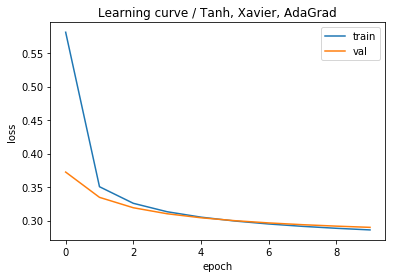

In [28]:
# 1層目がconv1D　パディングあり、ストライドあり
# エポック１０
# 推定　→　Accuracy
y_pred = conv1d_PS.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(conv1d_PS.train_loss, label='train')
plt.plot(conv1d_PS.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / Tanh, Xavier, AdaGrad')
plt.legend()
plt.show()